# NEURAL STYLE TRANSFER 

### IMPORTING THE VARIOUS LIBRARIES REQUIRED

In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms,models
import time

### LOADING THE VGG16 MODEL

In [2]:
vgg=models.vgg13(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

### TRANSFERRING THE MODEL TO GPU IF AVAILABLE

In [3]:
devices=torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(devices)
devices

device(type='cuda')

### LOADING THE CONTENT AND STYLE IMAGES

In [4]:
def load_image(img_path,max_size=400,shape=None):
    image=Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size=max_size
    else:
        size=max(image.size)
    if shape is not None:
        size=shape
    
    in_transform=transforms.Compose([transforms.Resize(size),transforms.ToTensor(),transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image
    

In [5]:
content=load_image('images/space_needle.jpg').to(devices)

style=load_image('images/hockney.jpg',shape=content.shape[-2:]).to(devices)

In [6]:
def im_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image

### VISUALIZING OUR CONTENT AND STYLE IMAGE

tensor([[[[-0.2513, -0.2513, -0.2342,  ...,  0.1768,  0.1768,  0.1597],
          [-0.2342, -0.2513, -0.2342,  ...,  0.1768,  0.1768,  0.1426],
          [-0.2684, -0.2856, -0.2513,  ...,  0.1597,  0.1597,  0.1426],
          ...,
          [-1.3302, -1.4158, -1.5014,  ..., -1.4500, -1.5014, -1.5185],
          [-1.4158, -1.5185, -1.7069,  ..., -1.4500, -1.5185, -1.5014],
          [-1.4672, -1.6555, -1.8782,  ..., -1.4329, -1.5357, -1.4843]],

         [[ 0.4503,  0.4503,  0.4503,  ...,  0.6604,  0.6429,  0.6254],
          [ 0.4503,  0.4328,  0.4328,  ...,  0.6604,  0.6429,  0.6078],
          [ 0.4328,  0.4153,  0.4328,  ...,  0.6779,  0.6429,  0.6078],
          ...,
          [-1.3880, -1.5105, -1.6155,  ..., -1.6856, -1.7556, -1.7906],
          [-1.4405, -1.6155, -1.8081,  ..., -1.6856, -1.7731, -1.7731],
          [-1.5455, -1.7556, -1.9657,  ..., -1.7031, -1.7906, -1.7731]],

         [[ 1.4200,  1.4200,  1.4374,  ...,  1.5768,  1.5594,  1.5420],
          [ 1.4200,  1.4025,  

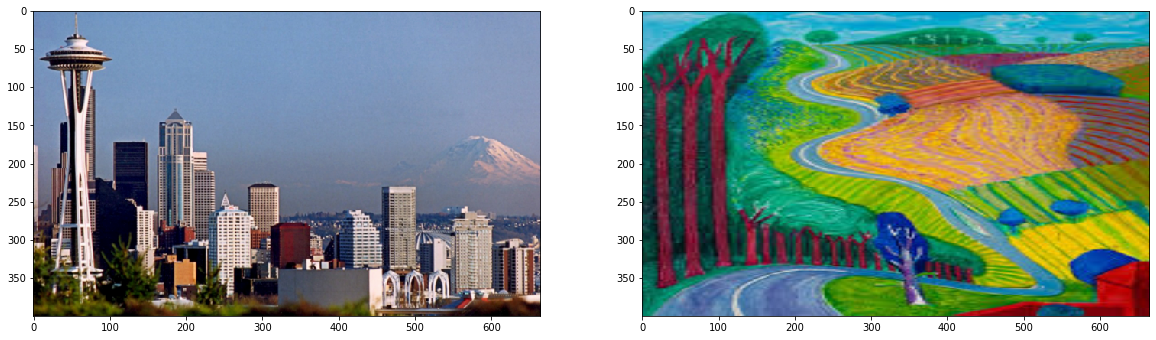

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
print(content)
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### PRINTING THE VARIOUS LAYERS OF THE VGG16 MODEL

In [8]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=True)
  (17): Conv2d(512, 512, kernel_si

### CONTENT AND STYLE FEATURES

In [9]:
def get_features(image,model,layers=None):
    
    if layers is None:
        layers={'0':'conv1_1',
                '5':'conv2_1',
                '10':'conv3_1',
                '19':'conv3_2',
                '21':'conv4_1'}
        
    features={}
    x=image
    for name,layer in model._modules.items():
        x=layer(x)
        if name in layers:
            features[layers[name]]=x
            
    return features


### CALCULATING THE GRAM MATRIX

In [10]:
def gram_matrix(tensor):
    _,d,h,w=tensor.size()
    tensor=tensor.view(d,h*w)
    gram=torch.mm(tensor,tensor.t())
    return gram

In [11]:
content_features=get_features(content,vgg)
style_features=get_features(style,vgg)

style_grams={layer: gram_matrix(style_features[layer]) for layer in style_features}

target=content.clone().requires_grad_(True).to(devices)

In [12]:
style_weights={'conv1_1':1.,
               'conv2_1':0.8,
               'conv3_1':0.5,
               'conv4_1':0.3}
target_weights={'conv3_2':1}
content_weight=1
style_weight=1e6

### UPDATING THE TARGET IMAGE AND CALCULATING LOSS

Total loss: 90053080.0


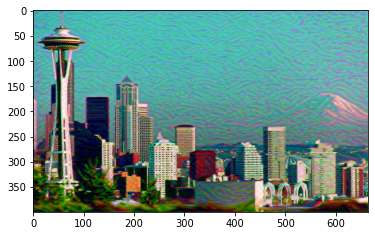

Time: 24.766413688659668
Total loss: 45039392.0


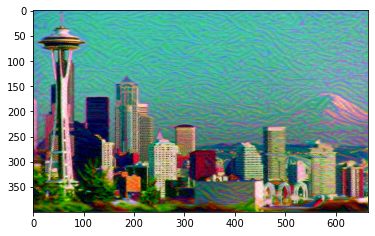

Time: 49.35696458816528
Total loss: 25668604.0


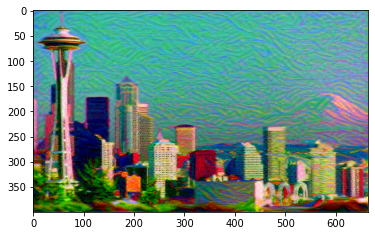

Time: 74.30930805206299
Total loss: 14839346.0


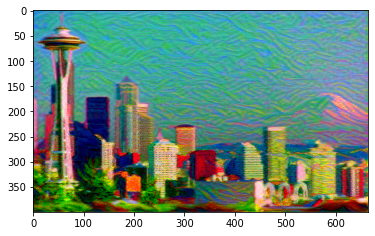

Time: 99.2090048789978
Total loss: 9064543.0


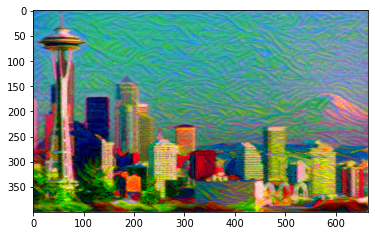

Time: 123.93163061141968
123.93363213539124


In [13]:
start = time.time()
show_every=400

optimizer=optim.Adam([target],lr=0.003)
steps=2000

for ii in range(1,steps+1):
    target_features=get_features(target,vgg)
    content_loss=torch.mean((target_features['conv3_2']-content_features['conv3_2'])**2)
    
    style_loss=0
    for layer in style_weights:
        target_feature=target_features[layer]
        #print(layer)
        target_gram=gram_matrix(target_feature)
        _,d,h,w=target_feature.shape
        style_gram=style_grams[layer]
        layer_style_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
        style_loss+=layer_style_loss/(d*h*w)
    
    total_loss=content_weight*content_loss+style_weight*style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if ii% show_every==0:
        print('Total loss:',total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
        print('Time:',time.time() - start)
print(time.time() - start)

### DISPLAYING FINAL TARGET IMAGE

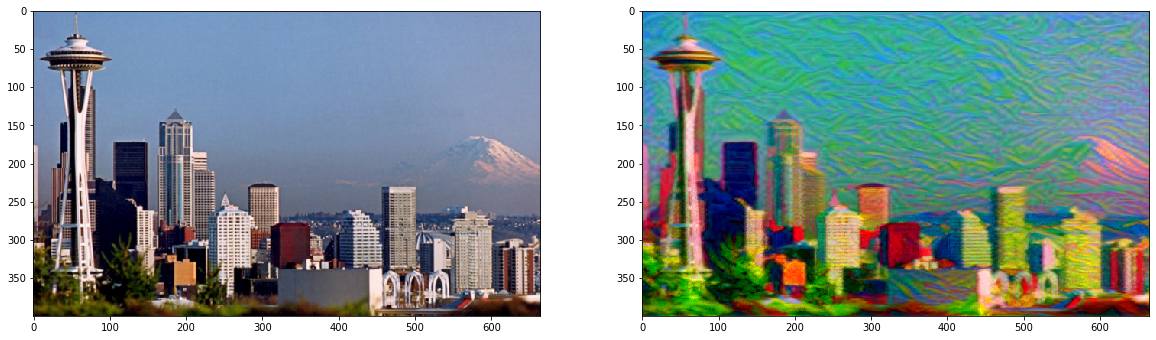

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))